LOADING AND INSPECTING DATA
Original dataset shape: (722, 3027)
Total columns: 3027
Total rows: 722

MISSING DATA ANALYSIS
Columns with >50% missing data: 1271

Top 20 columns with highest missing data:
                    Column  Missing_Count  Missing_Percentage
           studyAbroad_2_5            722               100.0
           studyAbroad_1_5            722               100.0
          studyAbroadF_4_6            722               100.0
                   vegan_8            722               100.0
               sugarfree_8            722               100.0
prescriptiondrugabuse3rc_2            722               100.0
          studyAbroadF_6_5            722               100.0
          studyAbroadF_5_5            722               100.0
          studyAbroadF_3_6            722               100.0
                   amin3_1            722               100.0
                 hawaii1_1            722               100.0
           studyAbroad_4_5            722            

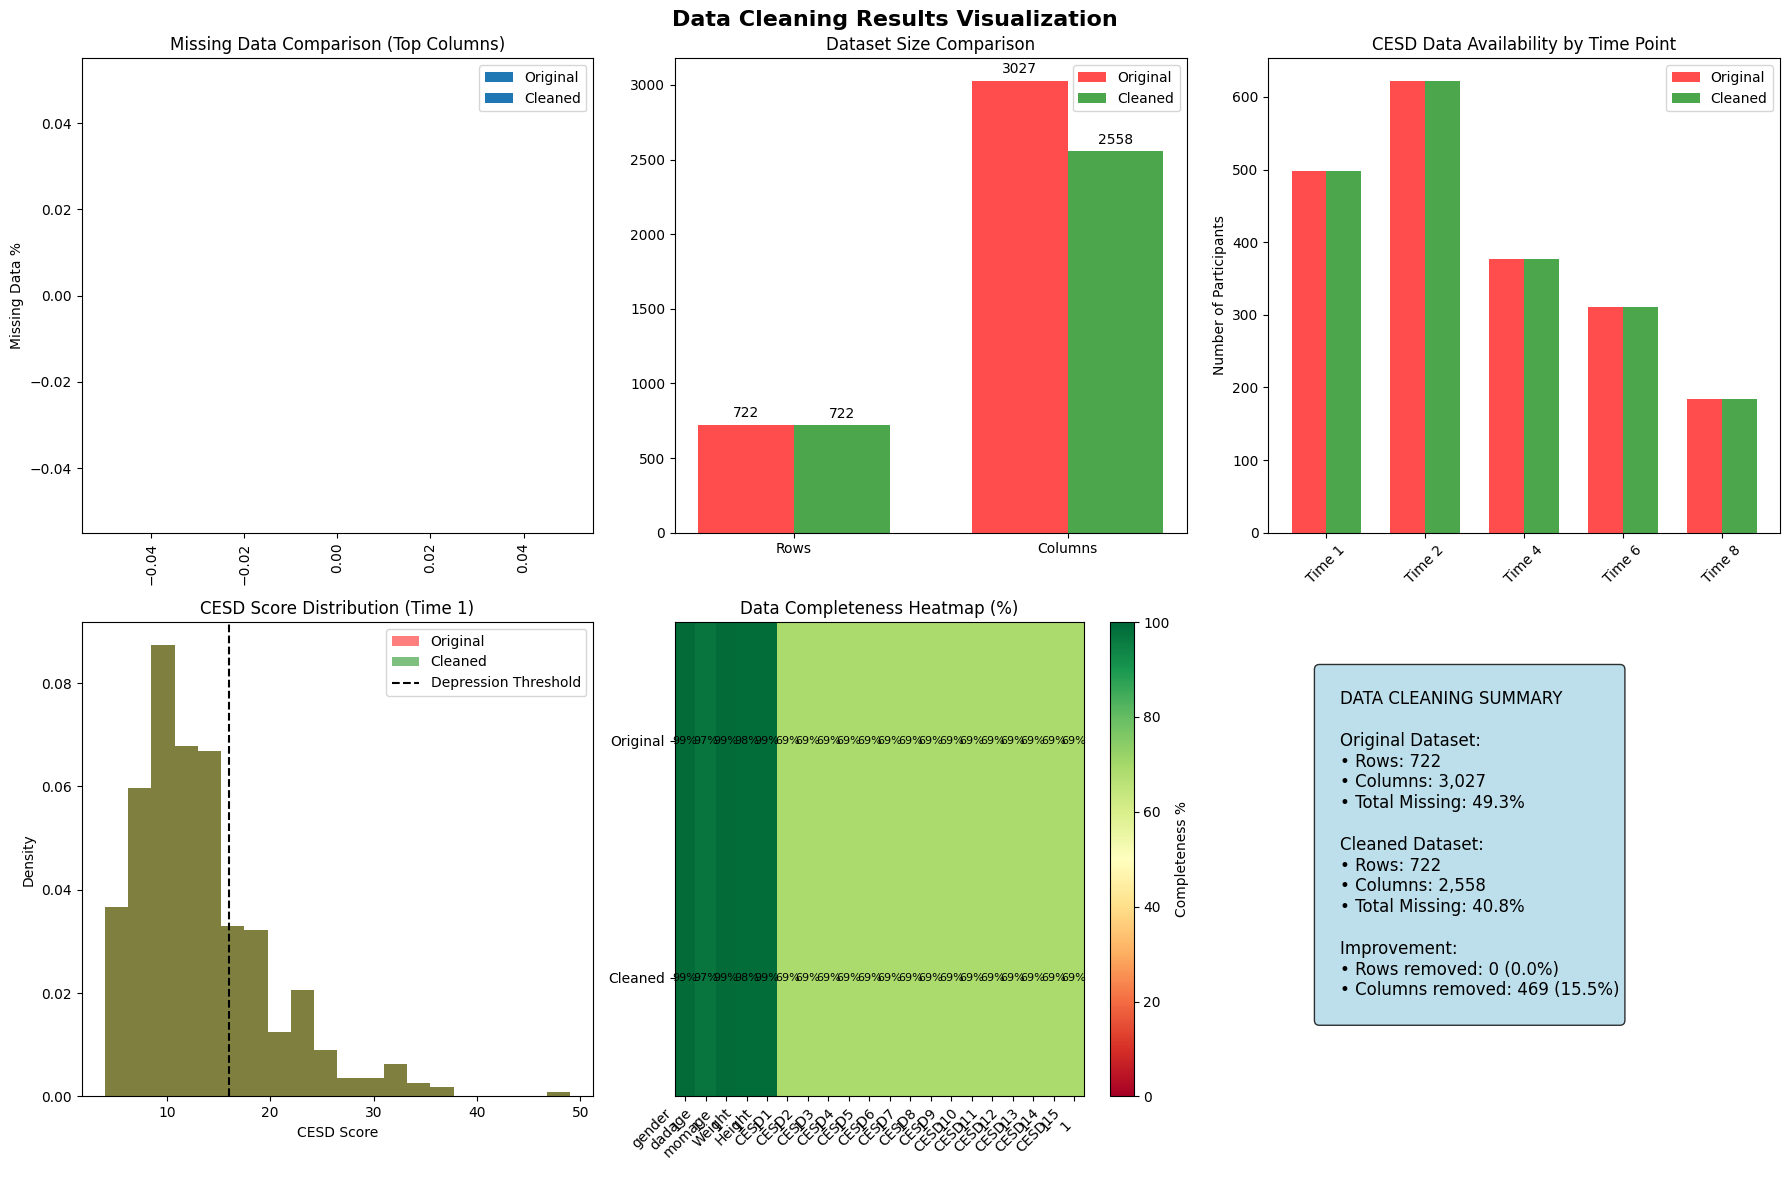


Cleaned dataset saved as: BasicSurvey3620_cleaned.csv

RECOMMENDATIONS FOR FURTHER ANALYSIS
1. Consider imputation methods for missing depression scores if sample size is critical
2. Validate cleaning decisions with domain experts
3. Document all cleaning steps for reproducibility
4. Consider creating separate datasets for different analysis purposes
5. Perform sensitivity analysis to test robustness of results to cleaning decisions


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def load_and_inspect_data(file_path):
    """Load data and provide initial inspection"""
    print("="*60)
    print("LOADING AND INSPECTING DATA")
    print("="*60)
    
    df = pd.read_csv(file_path)
    print(f"Original dataset shape: {df.shape}")
    print(f"Total columns: {df.shape[1]}")
    print(f"Total rows: {df.shape[0]}")
    
    return df

def analyze_missing_data(df):
    """Analyze missing data patterns"""
    print("\n" + "="*60)
    print("MISSING DATA ANALYSIS")
    print("="*60)
    
    # Calculate missing data percentages
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': missing_percent.values
    }).sort_values('Missing_Percentage', ascending=False)
    
    # Show columns with high missing data
    high_missing = missing_df[missing_df['Missing_Percentage'] > 50]
    print(f"Columns with >50% missing data: {len(high_missing)}")
    
    if len(high_missing) > 0:
        print("\nTop 20 columns with highest missing data:")
        print(high_missing.head(20).to_string(index=False))
    
    # Missing data by time points for key variables
    cesd_cols = [col for col in df.columns if 'CESDOverall' in col]
    bdi_cols = [col for col in df.columns if 'BDIsum' in col]
    
    print(f"\nMissing data for CESD scores:")
    for col in cesd_cols:
        if col in df.columns:
            missing_pct = (df[col].isnull().sum() / len(df)) * 100
            print(f"  {col}: {missing_pct:.1f}% missing")
    
    print(f"\nMissing data for BDI scores:")
    for col in bdi_cols:
        if col in df.columns:
            missing_pct = (df[col].isnull().sum() / len(df)) * 100
            print(f"  {col}: {missing_pct:.1f}% missing")
    
    return missing_df

def identify_outliers(df):
    """Identify outliers in depression scores"""
    print("\n" + "="*60)
    print("OUTLIER DETECTION")
    print("="*60)
    
    outlier_info = {}
    
    # Check CESD scores (valid range typically 0-60)
    cesd_cols = [col for col in df.columns if 'CESDOverall' in col]
    for col in cesd_cols:
        if col in df.columns:
            scores = df[col].dropna()
            if len(scores) > 0:
                # Statistical outliers using IQR
                Q1 = scores.quantile(0.25)
                Q3 = scores.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers = scores[(scores < lower_bound) | (scores > upper_bound)]
                
                # Also check for impossible values
                impossible_values = scores[(scores < 0) | (scores > 60)]
                
                outlier_info[col] = {
                    'statistical_outliers': len(outliers),
                    'impossible_values': len(impossible_values),
                    'min_value': scores.min(),
                    'max_value': scores.max(),
                    'valid_range': (0, 60)
                }
                
                print(f"{col}:")
                print(f"  Range: {scores.min():.1f} - {scores.max():.1f}")
                print(f"  Statistical outliers (IQR method): {len(outliers)}")
                print(f"  Impossible values (outside 0-60): {len(impossible_values)}")
                if len(impossible_values) > 0:
                    print(f"  Impossible values: {list(impossible_values)}")
    
    # Check BDI scores (valid range typically 0-63)
    bdi_cols = [col for col in df.columns if 'BDIsum' in col]
    for col in bdi_cols:
        if col in df.columns:
            scores = df[col].dropna()
            if len(scores) > 0:
                impossible_values = scores[(scores < 0) | (scores > 63)]
                outlier_info[col] = {
                    'impossible_values': len(impossible_values),
                    'min_value': scores.min(),
                    'max_value': scores.max(),
                    'valid_range': (0, 63)
                }
                
                print(f"{col}:")
                print(f"  Range: {scores.min():.1f} - {scores.max():.1f}")
                print(f"  Impossible values (outside 0-63): {len(impossible_values)}")
    
    return outlier_info

def check_data_consistency(df):
    """Check for data consistency issues"""
    print("\n" + "="*60)
    print("DATA CONSISTENCY CHECKS")
    print("="*60)
    
    consistency_issues = []
    
    # Check if CESD scores match CESD groups
    cesd_score_cols = [col for col in df.columns if 'CESDOverall' in col]
    cesd_group_cols = [col for col in df.columns if 'CESDGroup' in col]
    
    for i, (score_col, group_col) in enumerate(zip(cesd_score_cols, cesd_group_cols)):
        if score_col in df.columns and group_col in df.columns:
            # Create a subset with both values present
            subset = df[[score_col, group_col]].dropna()
            
            if len(subset) > 0:
                # Check consistency: score >=16 should be "Depressed"
                inconsistent = subset[
                    ((subset[score_col] >= 16) & (subset[group_col] == 'Not depressed')) |
                    ((subset[score_col] < 16) & (subset[group_col] == 'Depressed'))
                ]
                
                if len(inconsistent) > 0:
                    consistency_issues.append({
                        'issue': f'CESD score-group mismatch in {score_col}/{group_col}',
                        'count': len(inconsistent),
                        'percentage': (len(inconsistent) / len(subset)) * 100
                    })
                    print(f"Inconsistency in {score_col}/{group_col}: {len(inconsistent)} cases ({(len(inconsistent)/len(subset)*100):.1f}%)")
    
    # Check for duplicate participants
    if 'egoid' in df.columns:
        duplicates = df['egoid'].duplicated().sum()
        if duplicates > 0:
            consistency_issues.append({
                'issue': 'Duplicate participant IDs',
                'count': duplicates
            })
            print(f"Duplicate participant IDs: {duplicates}")
    
    # Check date consistency
    date_cols = [col for col in df.columns if 'Date' in col]
    for i in range(1, 9):  # Assuming up to 8 time points
        start_col = f'StartDate_{i}'
        end_col = f'EndDate_{i}'
        
        if start_col in df.columns and end_col in df.columns:
            # Convert to datetime (this will help identify invalid dates)
            try:
                start_dates = pd.to_datetime(df[start_col], errors='coerce')
                end_dates = pd.to_datetime(df[end_col], errors='coerce')
                
                # Check if end date is after start date
                invalid_dates = (end_dates < start_dates).sum()
                if invalid_dates > 0:
                    consistency_issues.append({
                        'issue': f'End date before start date in time point {i}',
                        'count': invalid_dates
                    })
                    print(f"Invalid date sequences in time point {i}: {invalid_dates}")
            except:
                print(f"Could not parse dates for time point {i}")
    
    return consistency_issues

def clean_dataset(df, cleaning_options=None):
    """Clean the dataset based on specified options"""
    print("\n" + "="*60)
    print("CLEANING DATASET")
    print("="*60)
    
    if cleaning_options is None:
        cleaning_options = {
            'remove_high_missing_cols': True,
            'missing_threshold': 80,  # Remove columns with >80% missing
            'remove_invalid_scores': True,
            'remove_inconsistent_data': True,
            'remove_empty_rows': True,
            'standardize_missing_values': True
        }
    
    df_clean = df.copy()
    cleaning_log = []
    
    print(f"Starting with {df_clean.shape[0]} rows and {df_clean.shape[1]} columns")
    
    # 1. Standardize missing values
    if cleaning_options.get('standardize_missing_values', True):
        # Replace various missing value representations with NaN
        missing_values = ['', ' ', 'N/A', 'n/a', 'NA', 'null', 'NULL', 'None', '-999', -999, 999, 99999]
        df_clean = df_clean.replace(missing_values, np.nan)
        cleaning_log.append("Standardized missing value representations")
    
    # 2. Remove columns with excessive missing data
    if cleaning_options.get('remove_high_missing_cols', True):
        threshold = cleaning_options.get('missing_threshold', 80)
        missing_pct = (df_clean.isnull().sum() / len(df_clean)) * 100
        high_missing_cols = missing_pct[missing_pct > threshold].index.tolist()
        
        df_clean = df_clean.drop(columns=high_missing_cols)
        cleaning_log.append(f"Removed {len(high_missing_cols)} columns with >{threshold}% missing data")
        print(f"Removed {len(high_missing_cols)} columns with >{threshold}% missing data")
    
    # 3. Remove rows that are completely empty or have no key data
    if cleaning_options.get('remove_empty_rows', True):
        # Identify key columns (depression scores, basic demographics)
        key_cols = []
        key_cols.extend([col for col in df_clean.columns if 'CESDOverall' in col])
        key_cols.extend([col for col in df_clean.columns if 'BDIsum' in col])
        key_cols.extend([col for col in df_clean.columns if col in ['egoid', 'gender_1', 'age']])
        
        # Remove rows where all key columns are missing
        if key_cols:
            before_rows = len(df_clean)
            df_clean = df_clean.dropna(subset=key_cols, how='all')
            removed_rows = before_rows - len(df_clean)
            if removed_rows > 0:
                cleaning_log.append(f"Removed {removed_rows} completely empty rows")
                print(f"Removed {removed_rows} rows with no key data")
    
    # 4. Remove invalid depression scores
    if cleaning_options.get('remove_invalid_scores', True):
        initial_rows = len(df_clean)
        
        # Clean CESD scores (valid range 0-60)
        cesd_cols = [col for col in df_clean.columns if 'CESDOverall' in col]
        for col in cesd_cols:
            invalid_mask = (df_clean[col] < 0) | (df_clean[col] > 60)
            df_clean.loc[invalid_mask, col] = np.nan
        
        # Clean BDI scores (valid range 0-63)
        bdi_cols = [col for col in df_clean.columns if 'BDIsum' in col]
        for col in bdi_cols:
            invalid_mask = (df_clean[col] < 0) | (df_clean[col] > 63)
            df_clean.loc[invalid_mask, col] = np.nan
        
        cleaning_log.append("Set invalid depression scores to NaN")
        print("Cleaned invalid depression scores")
    
    # 5. Fix inconsistent CESD score-group pairs
    if cleaning_options.get('remove_inconsistent_data', True):
        cesd_score_cols = [col for col in df_clean.columns if 'CESDOverall' in col]
        cesd_group_cols = [col for col in df_clean.columns if 'CESDGroup' in col]
        
        fixed_inconsistencies = 0
        for score_col, group_col in zip(cesd_score_cols, cesd_group_cols):
            if score_col in df_clean.columns and group_col in df_clean.columns:
                # Fix inconsistent group labels based on scores
                mask_depressed = (df_clean[score_col] >= 16) & (df_clean[group_col] == 'Not depressed')
                mask_not_depressed = (df_clean[score_col] < 16) & (df_clean[group_col] == 'Depressed')
                
                df_clean.loc[mask_depressed, group_col] = 'Depressed'
                df_clean.loc[mask_not_depressed, group_col] = 'Not depressed'
                
                fixed_inconsistencies += mask_depressed.sum() + mask_not_depressed.sum()
        
        if fixed_inconsistencies > 0:
            cleaning_log.append(f"Fixed {fixed_inconsistencies} inconsistent CESD score-group pairs")
            print(f"Fixed {fixed_inconsistencies} inconsistent CESD score-group pairs")
    
    # 6. Remove participants with no depression data at any time point
    depression_cols = []
    depression_cols.extend([col for col in df_clean.columns if 'CESDOverall' in col])
    depression_cols.extend([col for col in df_clean.columns if 'BDIsum' in col])
    
    if depression_cols:
        before_rows = len(df_clean)
        df_clean = df_clean.dropna(subset=depression_cols, how='all')
        removed_rows = before_rows - len(df_clean)
        if removed_rows > 0:
            cleaning_log.append(f"Removed {removed_rows} participants with no depression data")
            print(f"Removed {removed_rows} participants with no depression data")
    
    print(f"\nFinal dataset: {df_clean.shape[0]} rows and {df_clean.shape[1]} columns")
    
    return df_clean, cleaning_log

def create_cleaning_report(df_original, df_clean, cleaning_log, outlier_info, consistency_issues):
    """Create a comprehensive cleaning report"""
    print("\n" + "="*60)
    print("DATA CLEANING REPORT")
    print("="*60)
    
    # Basic statistics
    original_shape = df_original.shape
    clean_shape = df_clean.shape
    
    print(f"Original dataset: {original_shape[0]} rows × {original_shape[1]} columns")
    print(f"Cleaned dataset: {clean_shape[0]} rows × {clean_shape[1]} columns")
    print(f"Rows removed: {original_shape[0] - clean_shape[0]} ({((original_shape[0] - clean_shape[0])/original_shape[0]*100):.1f}%)")
    print(f"Columns removed: {original_shape[1] - clean_shape[1]} ({((original_shape[1] - clean_shape[1])/original_shape[1]*100):.1f}%)")
    
    print(f"\nCleaning steps performed:")
    for i, step in enumerate(cleaning_log, 1):
        print(f"  {i}. {step}")
    
    # Data quality improvement
    print(f"\nData quality improvement:")
    
    # Missing data comparison
    original_missing = (df_original.isnull().sum().sum() / (df_original.shape[0] * df_original.shape[1])) * 100
    clean_missing = (df_clean.isnull().sum().sum() / (df_clean.shape[0] * df_clean.shape[1])) * 100
    
    print(f"  Overall missing data: {original_missing:.1f}% → {clean_missing:.1f}%")
    
    # Depression data availability
    cesd_cols = [col for col in df_clean.columns if 'CESDOverall' in col]
    if cesd_cols:
        participants_with_cesd_original = df_original[cesd_cols].notna().any(axis=1).sum()
        participants_with_cesd_clean = df_clean[cesd_cols].notna().any(axis=1).sum()
        
        print(f"  Participants with CESD data: {participants_with_cesd_original} → {participants_with_cesd_clean}")
    
    return {
        'original_shape': original_shape,
        'clean_shape': clean_shape,
        'cleaning_log': cleaning_log,
        'rows_removed': original_shape[0] - clean_shape[0],
        'columns_removed': original_shape[1] - clean_shape[1]
    }

def visualize_cleaning_results(df_original, df_clean):
    """Create visualizations showing the impact of data cleaning"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Data Cleaning Results Visualization', fontsize=16, fontweight='bold')
    
    # 1. Missing data comparison
    ax1 = axes[0, 0]
    missing_original = (df_original.isnull().sum() / len(df_original)) * 100
    missing_clean = (df_clean.isnull().sum() / len(df_clean)) * 100
    
    # Get common columns
    common_cols = list(set(df_original.columns) & set(df_clean.columns))
    if len(common_cols) > 50:  # Limit to prevent overcrowding
        # Select columns with highest missing data in original
        top_missing_cols = missing_original.nlargest(50).index
        common_cols = [col for col in top_missing_cols if col in common_cols]
    
    x_pos = range(len(common_cols))
    ax1.bar([x - 0.2 for x in x_pos], [missing_original[col] for col in common_cols], 
            width=0.4, label='Original', alpha=0.7, color='red')
    ax1.bar([x + 0.2 for x in x_pos], [missing_clean[col] for col in common_cols], 
            width=0.4, label='Cleaned', alpha=0.7, color='green')
    ax1.set_title('Missing Data Comparison (Top Columns)')
    ax1.set_ylabel('Missing Data %')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=90)
    
    # 2. Dataset size comparison
    ax2 = axes[0, 1]
    categories = ['Rows', 'Columns']
    original_values = [df_original.shape[0], df_original.shape[1]]
    clean_values = [df_clean.shape[0], df_clean.shape[1]]
    
    x = np.arange(len(categories))
    width = 0.35
    ax2.bar(x - width/2, original_values, width, label='Original', color='red', alpha=0.7)
    ax2.bar(x + width/2, clean_values, width, label='Cleaned', color='green', alpha=0.7)
    ax2.set_title('Dataset Size Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.legend()
    
    # Add value labels on bars
    for i, (orig, clean) in enumerate(zip(original_values, clean_values)):
        ax2.text(i - width/2, orig + max(original_values)*0.01, str(orig), ha='center', va='bottom')
        ax2.text(i + width/2, clean + max(clean_values)*0.01, str(clean), ha='center', va='bottom')
    
    # 3. Depression data availability
    ax3 = axes[0, 2]
    cesd_cols = [col for col in df_clean.columns if 'CESDOverall' in col]
    if cesd_cols:
        timepoints = []
        original_counts = []
        clean_counts = []
        
        for col in cesd_cols:
            timepoint = col.split('_')[-1]
            timepoints.append(f'Time {timepoint}')
            
            if col in df_original.columns:
                original_counts.append(df_original[col].notna().sum())
            else:
                original_counts.append(0)
            
            clean_counts.append(df_clean[col].notna().sum())
        
        x = np.arange(len(timepoints))
        width = 0.35
        ax3.bar(x - width/2, original_counts, width, label='Original', color='red', alpha=0.7)
        ax3.bar(x + width/2, clean_counts, width, label='Cleaned', color='green', alpha=0.7)
        ax3.set_title('CESD Data Availability by Time Point')
        ax3.set_ylabel('Number of Participants')
        ax3.set_xticks(x)
        ax3.set_xticklabels(timepoints, rotation=45)
        ax3.legend()
    
    # 4. CESD score distribution comparison
    ax4 = axes[1, 0]
    if 'CESDOverall_1' in df_original.columns and 'CESDOverall_1' in df_clean.columns:
        original_scores = df_original['CESDOverall_1'].dropna()
        clean_scores = df_clean['CESDOverall_1'].dropna()
        
        ax4.hist(original_scores, bins=20, alpha=0.5, label='Original', color='red', density=True)
        ax4.hist(clean_scores, bins=20, alpha=0.5, label='Cleaned', color='green', density=True)
        ax4.axvline(16, color='black', linestyle='--', label='Depression Threshold')
        ax4.set_title('CESD Score Distribution (Time 1)')
        ax4.set_xlabel('CESD Score')
        ax4.set_ylabel('Density')
        ax4.legend()
    
    # 5. Data completeness heatmap
    ax5 = axes[1, 1]
    # Select key columns for heatmap
    key_columns = [col for col in df_clean.columns if any(keyword in col for keyword in 
                   ['CESD', 'BDI', 'gender', 'age', 'Weight', 'Height'])][:20]  # Limit to 20 columns
    
    if key_columns:
        completeness_data = []
        labels = ['Original', 'Cleaned']
        
        for dataset, label in [(df_original, 'Original'), (df_clean, 'Cleaned')]:
            row_completeness = []
            for col in key_columns:
                if col in dataset.columns:
                    completeness = (dataset[col].notna().sum() / len(dataset)) * 100
                else:
                    completeness = 0
                row_completeness.append(completeness)
            completeness_data.append(row_completeness)
        
        im = ax5.imshow(completeness_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
        ax5.set_xticks(range(len(key_columns)))
        ax5.set_xticklabels([col.replace('_', '\n') for col in key_columns], rotation=45, ha='right')
        ax5.set_yticks(range(len(labels)))
        ax5.set_yticklabels(labels)
        ax5.set_title('Data Completeness Heatmap (%)')
        
        # Add text annotations
        for i in range(len(labels)):
            for j in range(len(key_columns)):
                text = ax5.text(j, i, f'{completeness_data[i][j]:.0f}%',
                               ha="center", va="center", color="black", fontsize=8)
        
        plt.colorbar(im, ax=ax5, label='Completeness %')
    
    # 6. Summary statistics
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Create summary text
    summary_text = f"""
    DATA CLEANING SUMMARY
    
    Original Dataset:
    • Rows: {df_original.shape[0]:,}
    • Columns: {df_original.shape[1]:,}
    • Total Missing: {(df_original.isnull().sum().sum() / (df_original.shape[0] * df_original.shape[1]) * 100):.1f}%
    
    Cleaned Dataset:
    • Rows: {df_clean.shape[0]:,}
    • Columns: {df_clean.shape[1]:,}
    • Total Missing: {(df_clean.isnull().sum().sum() / (df_clean.shape[0] * df_clean.shape[1]) * 100):.1f}%
    
    Improvement:
    • Rows removed: {df_original.shape[0] - df_clean.shape[0]:,} ({((df_original.shape[0] - df_clean.shape[0])/df_original.shape[0]*100):.1f}%)
    • Columns removed: {df_original.shape[1] - df_clean.shape[1]:,} ({((df_original.shape[1] - df_clean.shape[1])/df_original.shape[1]*100):.1f}%)
    """
    
    ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def main():
    """Main function to run the complete data cleaning pipeline"""
    # Load data
    df_original = load_and_inspect_data('/home/grealish/summer/KAN_NET/BasicSurvey(3-6-20).csv')
    
    # Analyze data quality issues
    missing_df = analyze_missing_data(df_original)
    outlier_info = identify_outliers(df_original)
    consistency_issues = check_data_consistency(df_original)
    
    # Define cleaning options
    cleaning_options = {
        'remove_high_missing_cols': True,
        'missing_threshold': 80,  # Remove columns with >80% missing data
        'remove_invalid_scores': True,
        'remove_inconsistent_data': True,
        'remove_empty_rows': True,
        'standardize_missing_values': True
    }
    
    # Clean the dataset
    df_clean, cleaning_log = clean_dataset(df_original, cleaning_options)
    
    # Create comprehensive report
    report = create_cleaning_report(df_original, df_clean, cleaning_log, outlier_info, consistency_issues)
    
    # Visualize results
    visualize_cleaning_results(df_original, df_clean)
    
    # Save cleaned dataset
    output_filename = 'BasicSurvey3620_cleaned.csv'
    df_clean.to_csv(output_filename, index=False)
    print(f"\nCleaned dataset saved as: {output_filename}")
    
    # Additional recommendations
    print("\n" + "="*60)
    print("RECOMMENDATIONS FOR FURTHER ANALYSIS")
    print("="*60)
    print("1. Consider imputation methods for missing depression scores if sample size is critical")
    print("2. Validate cleaning decisions with domain experts")
    print("3. Document all cleaning steps for reproducibility")
    print("4. Consider creating separate datasets for different analysis purposes")
    print("5. Perform sensitivity analysis to test robustness of results to cleaning decisions")
    
    return df_clean, report

# Run the cleaning pipeline
if __name__ == "__main__":
    df_cleaned, cleaning_report = main()